Setup
====

In [1]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import Years and IPC Classes Data
===

In [2]:
# data_directory = '../data/'

In [3]:
# IPC_patent_attributes = pd.read_csv('../Data/pid_issdate_ipc.csv')
# IPC_patent_attributes.ISSDATE = IPC_patent_attributes.ISSDATE.map(lambda x: int(x[-4:]))
# IPC_patent_attributes.rename(columns={
#                     'ISSDATE': 'Year',
#                     'IPC3': 'Class_IPC',
#                     'PID': 'Patent',
#                     },
#                  inplace=True)
IPC_patent_attributes = pd.read_csv(data_directory+'patent_ipc_1976_2010.csv',
                                   names=['Patent', 'Class_IPC', 'Class_IPC4', 'Year'])
IPC_patent_attributes.Year = IPC_patent_attributes.Year.map(lambda x: int(x[-4:]))

IPC_patent_attributes.set_index('Patent', inplace=True)

### Convert the alphanumeric IPC classes to a purely numeric system, and store in the conversion in a lookup table
# IPC_classes = sort(IPC_patent_attributes['Class_IPC'].unique())
# IPC_class_lookup = pd.Series(index=IPC_classes,
#                       data=arange(len(IPC_classes)))
IPC_class_lookup = pd.read_hdf(data_directory+'class_lookup_tables.h5', 'IPC_class_lookup')
IPC_patent_attributes['Class_IPC'] = IPC_class_lookup.ix[IPC_patent_attributes['Class_IPC']].values

### Convert the alphanumeric IPC4 classes to a purely numeric system, and store in the conversion in a lookup table
# IPC4_classes = sort(IPC_patent_attributes['Class_IPC4'].unique())
# IPC4_class_lookup = pd.Series(index=IPC4_classes,
#                       data=arange(len(IPC4_classes)))
IPC4_class_lookup = pd.read_hdf(data_directory+'class_lookup_tables.h5', 'IPC4_class_lookup')
IPC_patent_attributes['Class_IPC4'] = IPC4_class_lookup.ix[IPC_patent_attributes['Class_IPC4']].values

Import USPC Classes Data
===

In [52]:
USPC_patent_attributes = pd.read_csv(data_directory+'PATENT_US_CLASS_SUBCLASSES_1975_2011.csv',
                               header=None,
                               names=['Patent', 'Class_USPC', 'Subclass_USPC'])

#Hope that the first class associated with each patent is the "main" class
USPC_patent_attributes.drop_duplicates(["Patent"], inplace=True) 

USPC_patent_attributes.set_index('Patent', inplace=True)
# USPC_patent_attributes.ix[:,'Class_USPC'] = USPC_patent_attributes['Class_USPC'].map(lambda x: x if type(x)==int else int(x) if x.isdigit() else nan)
# USPC_patent_attributes.dropna(inplace=True)
USPC_patent_attributes.drop(['Subclass_USPC'], axis=1, inplace=True)

### Convert the non-contiguous USPC classes to a contiguous numeric system, and store in the conversion in a lookup table
# USPC_classes = sort(USPC_patent_attributes['Class_USPC'].unique())
# USPC_class_lookup = pd.Series(index=USPC_classes,
#                       data=arange(len(USPC_classes)))
USPC_class_lookup = pd.read_hdf(data_directory+'class_lookup_tables.h5', 'USPC_class_lookup')
USPC_patent_attributes['Class_USPC'] = USPC_class_lookup.ix[USPC_patent_attributes['Class_USPC']].values

In [54]:
patent_attributes = IPC_patent_attributes.merge(USPC_patent_attributes,
                                               right_index=True,
                                               left_index=True)

Import Citation Data and Add Patent Attributes
===

In [55]:
citations = pd.read_csv(data_directory+'citing_cited.csv', header=None, names=['Citing_Patent', 'Cited_Patent'])

citations.Cited_Patent = citations.Cited_Patent.map(lambda x: x if type(x)==int else int(x) if x.isdigit() else nan)

citations.dropna(inplace=True)

citations.drop_duplicates(inplace=True)

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [56]:
citations_made_per_patent = citations['Citing_Patent'].value_counts()
citations_received_per_patent = citations['Cited_Patent'].value_counts()

patent_attributes['Citations_Made'] = citations_made_per_patent.ix[patent_attributes.index]
patent_attributes['Citations_Recieved'] = citations_received_per_patent.ix[patent_attributes.index]

In [57]:
citations = citations.merge(patent_attributes, 
                left_on='Citing_Patent', 
                right_index=True,
                )

citations = citations.merge(patent_attributes, 
                left_on='Cited_Patent', 
                right_index=True,
                suffixes=('_Citing_Patent','_Cited_Patent'))

Remove obviously incorrect/error data
===

In [58]:
# Removes citations in which the cited patent is two years or more YOUNGER than the citing patent
# This shouldn't happen, but does, due to typos in the USPTO data -_-
citations = citations[citations.Year_Citing_Patent >= citations.Year_Cited_Patent-2]

In [59]:
citations['Same_Class_IPC'] = citations.Class_IPC_Cited_Patent==citations.Class_IPC_Citing_Patent
citations['Same_Class_IPC4'] = citations.Class_IPC4_Cited_Patent==citations.Class_IPC4_Citing_Patent
citations['Same_Class_USPC'] = citations.Class_USPC_Cited_Patent==citations.Class_USPC_Citing_Patent

In [60]:
same_class_ind = citations['Same_Class_IPC']==True
same_class_group_sizes = citations.ix[same_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    'Class_IPC_Citing_Patent', 
    ])['Cited_Patent'].count()

cross_class_ind = -same_class_ind
cross_class_group_sizes = citations.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    ])['Cited_Patent'].count()

group_sizes_IPC = concatenate((same_class_group_sizes.values, cross_class_group_sizes.values))

####
same_class_ind = citations['Same_Class_IPC4']==True
same_class_group_sizes = citations.ix[same_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    'Class_IPC_Citing_Patent', 
    ])['Cited_Patent'].count()

cross_class_ind = -same_class_ind
cross_class_group_sizes = citations.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    ])['Cited_Patent'].count()

group_sizes_IPC4 = concatenate((same_class_group_sizes.values, cross_class_group_sizes.values))

####
same_class_ind = citations['Same_Class_USPC']==True
same_class_group_sizes = citations.ix[same_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    'Class_USPC_Citing_Patent', 
    ])['Cited_Patent'].count()

cross_class_ind = -same_class_ind
cross_class_group_sizes = citations.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    ])['Cited_Patent'].count()
group_sizes_USPC = concatenate((same_class_group_sizes.values, cross_class_group_sizes.values))

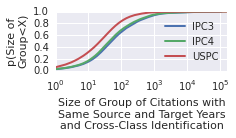

In [63]:
sns.set_style("darkgrid")
fig_one_col = 3.4252#3.35
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))

import powerlaw
x, y = powerlaw.cdf(group_sizes_IPC)
plot(x-1, y, linewidth=2, label='IPC3')

x, y = powerlaw.cdf(group_sizes_IPC4)
plot(x-1, y, linewidth=2, label='IPC4')

x, y = powerlaw.cdf(group_sizes_USPC)
plot(x-1, y, linewidth=2, label='USPC')
xscale('log')
xlim(xmax=max(x))
legend(loc=4)

xlabel("Size of Group of Citations with\n"
       "Same Source and Target Years\n"
       "and Cross-Class Identification")
ylabel("p(Size of\nGroup<X)")

tight_layout()
sns.despine()
figures_directory = '../manuscript/figs/'
filename = 'Citation_Group_Sizes'
savefig(figures_directory+filename+'.pdf', bbox_inches='tight')


In [64]:
store = pd.HDFStore(data_directory+'citations_organized.h5', table=True)
store.put('/citations', citations, append=False)#'table', append=False)
store.put('/IPC_class_lookup', IPC_class_lookup, 'table', append=False)
store.put('/IPC4_class_lookup', IPC4_class_lookup, 'table', append=False)
store.put('/USPC_class_lookup', USPC_class_lookup, 'table', append=False)

store.put('/patent_attributes', patent_attributes, 'table', append=False)

store.close()